In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import random

import os
os.environ["PROJ_LIB"] = "C:\\Users\\gabri\\AppData\\Local\\Continuum\\anaconda3\\pkgs\\proj4-5.2.0-ha925a31_1\\Library\\share";
from mpl_toolkits.basemap import Basemap

import sys
sys.path.append("../../../../..")
from definitions import QUAKES_RAW_DATA_PATH
import networkx as nx

from earthquakes.quakes_util import custom_geo_distance, is_point_in_bbox, get_earthquakes_in_timespan, find_closest_station, UTCDateTime_to_string, \
    string_to_UTCDateTime, quake_filename_to_UTCDateTime, BadDataException, read_pickle, write_pickle, obtain_data, timeit_context, visualize_sensors_graph, create_weighted_adjacency_quakes, \
    visualize_quakes, resample_data, k_hop_reach, recalls_at_k_hops, precisions_at_k_hops, f1_scores_at_k_hops, compute_metrics_with_growing_radius, compute_metrics_with_growing_radius_v2
from utils.misc_utils import check_create_folder

from prediction.train_utils import plot_cm

In [2]:
# taken from https://www.openstreetmap.org/export
bounding_box = [
    166.104, # left lower corner longitude
    178.990, # upper right corner longitude
    -47.749, # left lower corner latitude
    -33.779, # upper right corner latitude
]

nz_basemap = Basemap(
        projection='merc',
        llcrnrlon=bounding_box[0],  # left lower corner longitude
        llcrnrlat=bounding_box[2],  # left lower corner latitude
        urcrnrlon=bounding_box[1],
        urcrnrlat=bounding_box[3],
        lat_ts=0,
        resolution='c',
        suppress_ticks=True)


colors={
    'GTCNN': "forestgreen",
    'LSTM': "goldenrod",
    'GGRNN': "darkred",
    'Random': "fuchsia"
}

C:\Users\gabri\AppData\Local\Continuum\anaconda3\envs\tud_ml4se\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


In [3]:
NEW_DATASET_FOLDER = os.path.join(QUAKES_RAW_DATA_PATH, "new_dataset_gabriele")
stations_in_bbox = pd.read_csv(os.path.join(NEW_DATASET_FOLDER, "stations_in_bbox.csv"))
weighted_adjacency = np.load(os.path.join(NEW_DATASET_FOLDER, "packaged", "weighted_adjacency.npy"))
distances_matrix = np.load(os.path.join(NEW_DATASET_FOLDER, "packaged", "pairwise_distances.npy"))

stations_in_bbox.head()

Unnamed: 0 #network station   latitude   longitude  elevation  \
0           0       NZ     BFZ -40.679647  176.246245      283.0   
1           1       NZ     BHW -41.408231  174.871115      101.0   
2           2       NZ     BKZ -39.165666  176.492544      706.0   
3           3       NZ    COVZ -39.199914  175.542402     1133.0   
4           4       NZ     CVZ -44.383180  171.006160      454.0   

              sitename            starttime  endtime  
0           Birch Farm  1996-04-03T00:00:00      NaN  
1          Baring Head  1975-11-27T00:00:00      NaN  
2     Black Stump Farm  2004-02-11T00:00:00      NaN  
3  Chateau Observatory  1998-03-25T00:00:00      NaN  
4                 Cave  2014-05-16T00:00:00      NaN

In [4]:
classToLabel_dict_path = r"C:\Users\gabri\Desktop\new_thesis_project\earthquakes\data\new_dataset_gabriele\packaged\class2label_dict.pickle"
LabelToClass_dict_path = r"C:\Users\gabri\Desktop\new_thesis_project\earthquakes\data\new_dataset_gabriele\packaged\label2class_dict.pickle"

classToLabel_dict = read_pickle(classToLabel_dict_path)
labelToClass_dict = read_pickle(LabelToClass_dict_path)

In [5]:
classToLabel_dict[22]

29

In [6]:
cm_type = "last"

GTCNN_cm_path = r"C:\Users\gabri\Desktop\exp_earthquakes\original_problem\GTCNN_conf_matrices\20200401091540\sum_of_confusion_matrices_15_iters_{}.npy".format(cm_type)
LSTM_cm_path = r"C:\Users\gabri\Desktop\exp_earthquakes\original_problem\LSTM_conf_matrices\20200421010224\sum_of_confusion_matrices_15_iters_{}.npy".format(cm_type)
GRNN_cm_path = r"C:\Users\gabri\Desktop\exp_earthquakes\original_problem\GRNN_conf_matrices\20200512193728\sum_of_confusion_matrices_15_iters_{}.npy".format(cm_type)


------------

In [7]:
def mimic_rnd_confusion_matrix(original_confusion_matrix):
    n_classes = original_confusion_matrix.shape[0]
    random_conf_matrix = np.zeros([n_classes, n_classes])
    
    for cls_index in range(n_classes):
        class_support = sum(original_confusion_matrix[cls_index])
        predictions = np.zeros([n_classes])

        for _ in range(class_support):
            rnd_index = random.randrange(0, n_classes, 1)
            predictions[rnd_index] += 1
        random_conf_matrix[cls_index] = predictions
    return random_conf_matrix

In [8]:
cm_GTCNN = np.load(GTCNN_cm_path)
cm_LSTM = np.load(LSTM_cm_path)
cm_GRNN = np.load(GRNN_cm_path)
cm_RANDOM = mimic_rnd_confusion_matrix(cm_GTCNN)

In [9]:
# # https://stackoverflow.com/questions/58373488/why-does-my-sklearn-metrics-confusion-matrix-output-look-transposed
figsize=(14, 11)

# plot_cm(cm_GTCNN, figsize=figsize, title="GTCNN")
# plot_cm(cm_LSTM, figsize=figsize, title="LSTM")
# plot_cm(cm_RANDOM, figsize=figsize, title="RANDOM")
# plot_cm(cm_GRNN, figsize=figsize, title="GRNN")

In [10]:
idx = 43

print(sum(cm_GTCNN[idx]))
print(sum(cm_LSTM[idx]))
print(sum(cm_RANDOM[idx]))
print(sum(cm_GRNN[idx]))

assert sum(cm_GTCNN[idx]) == sum(cm_LSTM[idx]) == sum(cm_RANDOM[idx]) == sum(cm_GRNN[idx])

345
345
345.0
345


In [11]:
# rnd_index = random.randint(0, cm_GTCNN.shape[0]-1)

# class_to_analyze = rnd_index



# station_to_analyze = classToLabel_dict[class_to_analyze] # station
# print(f"Class {class_to_analyze} corresponds to station {station_to_analyze}")

# predictions_for_class = cm_GTCNN[class_to_analyze]
# predictions_for_station = {classToLabel_dict[class_index]: n_pred_for_class for class_index, n_pred_for_class in enumerate(predictions_for_class)}
# non_zero_predictions_for_station = {k:v for k,v in predictions_for_station.items() if v > 0}


# predictions_north = 0
# predictions_south = 0
# for station_index,n_pred_for_station in non_zero_predictions_for_station.items():
#     if stations_in_bbox.region[station_index] == 'north':
#         predictions_north += n_pred_for_station
#     elif stations_in_bbox.region[station_index] == 'south':
#         predictions_south += n_pred_for_station
#     else:
#         raise ValueError()

# station_lats = list(stations_in_bbox.latitude.values)
# station_lons=list(stations_in_bbox.longitude.values)

# lats_to_plot = []
# lons_to_plot = []
# node_sizes = []
# node_colors = []

# for station_index, n_predicted in non_zero_predictions_for_station.items():
#     if station_index == station_to_analyze:
#         continue
        
#     for _ in range(n_predicted):
#         lats_to_plot.append(station_lats[station_index])
#         lons_to_plot.append(station_lons[station_index])
#         node_sizes.append(200)
#         node_colors.append('red')

# plt.figure(figsize=(10, 10)),




# mapped_stations_x, mapped_stations_y = nz_basemap(lons_to_plot, lats_to_plot)
# g = nx.Graph()

# positions={}
# for idx in range(len(mapped_stations_x)):
#     g.add_edge(idx, idx)
#     positions[idx] = (mapped_stations_x[idx], mapped_stations_y[idx])
   
# nx.draw_networkx(g, positions, node_size=node_sizes, node_color=node_colors, with_labels=False, alpha=0.5)

# target_g = nx.Graph()
# mapped_target_x, mapped_target_y = nz_basemap([station_lons[station_to_analyze]], [station_lats[station_to_analyze]])
# target_pos = {
#     0: (mapped_target_x[0], mapped_target_y[0])
# }
# target_g.add_edge(0, 0)
# nx.draw_networkx(target_g, target_pos, node_size=40, node_color='yellow', with_labels=False, alpha=1)

# nz_basemap.bluemarble()
# plt.tight_layout()
# title = f"Predictions for station {station_to_analyze} (yellow). Correct predictions: {predictions_for_station[station_to_analyze]}. \nPredictions south: {predictions_south} | predictions north: {predictions_north}"
# plt.title(title)
# plt.show()

Good ones: 41, 28, 23, 30, 44, 35, , 54, 2, 25, 18, 1, 8, 39, 43, 26,   
Good south: 15, 21, 22, 7         
Bad ones: 31, 9, 4, 20, 11, 3, 14, 42    
Neutral: 36, 34

# Neighborhood-based metrics

In [12]:
k_values = [0, 1]
n_of_decimals = 4

g = nx.from_numpy_array(weighted_adjacency)
nx.diameter(g)

# for cm, label in zip([cm_GTCNN, cm_LSTM, cm_GRNN], ['GTCNN', 'LSTM', 'GRNN']):
#     print(f"Computing on {label}...")
        
#     for k in k_values:


#         recalls, supports = recalls_at_k_hops(cm, k, weighted_adjacency, classToLabel_dict, n_of_decimals, verbose=False)
#         precisions, _ = precisions_at_k_hops(cm, k, weighted_adjacency, classToLabel_dict, n_of_decimals, verbose=False)
#         f1_scores, _ = f1_scores_at_k_hops(cm, k, weighted_adjacency, classToLabel_dict, n_of_decimals, verbose=False)

#         figsize = (12, 2)

#         x = np.arange(len(recalls))  # the label locations
#         width = 0.5  # the width of the bars

#         fig, ax = plt.subplots(figsize=figsize)
#         ax.bar(x, recalls, width)

#         ax.set_ylabel('Class')
#         ax.set_title(f'Recall | k = {k} | {label}')
#         ax.set_xticks(x)
#         plt.ylim(0, 0.7)
#         plt.grid(alpha=0.3)
#         plt.tight_layout()
#         plt.show()

#         fig, ax = plt.subplots(figsize=figsize)
#         ax.bar(x, precisions, width)

#         ax.set_ylabel('Class')
#         ax.set_title(f'Precision | k = {k} | {label}')
#         ax.set_xticks(x)
#         plt.ylim(0, 0.7)
#         plt.grid(alpha=0.3)
#         plt.tight_layout()
#         plt.show()

#         fig, ax = plt.subplots(figsize=figsize)
#         ax.bar(x, f1_scores, width)

#         ax.set_ylabel('Class')
#         ax.set_title(f'f1 score | k = {k} | {label}')
#         ax.set_xticks(x)
#         plt.ylim(0, 0.7)
#         plt.grid(alpha=0.3)
#         plt.tight_layout()
#         plt.show()

11

In [14]:
# fig = plt.figure(figsize=(14, 3))

# for k in [0, 1, 2]:
    
#     recalls_GTCNN, supports = recalls_at_k_hops(cm_GTCNN, k, weighted_adjacency, classToLabel_dict, n_of_decimals, verbose=False)
#     precisions_GTCNN, _ = precisions_at_k_hops(cm_GTCNN, k, weighted_adjacency, classToLabel_dict, n_of_decimals, verbose=False)
#     f1_scores_GTCNN, _ = f1_scores_at_k_hops(cm_GTCNN, k, weighted_adjacency, classToLabel_dict, n_of_decimals, verbose=False)

#     recalls_LSTM, supports = recalls_at_k_hops(cm_LSTM, k, weighted_adjacency, classToLabel_dict, n_of_decimals, verbose=False)
#     precisions_LSTM, _ = precisions_at_k_hops(cm_LSTM, k, weighted_adjacency, classToLabel_dict, n_of_decimals, verbose=False)
#     f1_scores_LSTM, _ = f1_scores_at_k_hops(cm_LSTM, k, weighted_adjacency, classToLabel_dict, n_of_decimals, verbose=False)

#     recalls_GRNN, supports = recalls_at_k_hops(cm_GRNN, k, weighted_adjacency, classToLabel_dict, n_of_decimals, verbose=False)
#     precisions_GRNN, _ = precisions_at_k_hops(cm_GRNN, k, weighted_adjacency, classToLabel_dict, n_of_decimals, verbose=False)
#     f1_scores_GRNN, _ = f1_scores_at_k_hops(cm_GRNN, k, weighted_adjacency, classToLabel_dict, n_of_decimals, verbose=False)

#     recalls_RANDOM, supports = recalls_at_k_hops(cm_RANDOM, k, weighted_adjacency, classToLabel_dict, n_of_decimals, verbose=False)
#     precisions_RANDOM, _ = precisions_at_k_hops(cm_RANDOM, k, weighted_adjacency, classToLabel_dict, n_of_decimals, verbose=False)
#     f1_scores_RANDOM, _ = f1_scores_at_k_hops(cm_RANDOM, k, weighted_adjacency, classToLabel_dict, n_of_decimals, verbose=False)

#     plt.subplot(1, 3, k+1)

#     w_mean_recall_GTCNN = round(np.average(recalls_GTCNN, weights=supports), 3)
#     w_mean_prec_GTCNN = round(np.average(precisions_GTCNN, weights=supports), 3)
#     w_mean_f1_GTCNN = round(np.average(f1_scores_GTCNN, weights=supports), 3)

#     w_mean_recall_LSTM = round(np.average(recalls_LSTM, weights=supports), 3)
#     w_mean_prec_LSTM = round(np.average(precisions_LSTM, weights=supports), 3)
#     w_mean_f1_LSTM = round(np.average(f1_scores_LSTM, weights=supports), 3)
    
#     w_mean_recall_GRNN = round(np.average(recalls_GRNN, weights=supports), 3)
#     w_mean_prec_GRNN = round(np.average(precisions_GRNN, weights=supports), 3)
#     w_mean_f1_GRNN = round(np.average(f1_scores_GRNN, weights=supports), 3)
    
#     w_mean_recall_RANDOM = round(np.average(recalls_RANDOM, weights=supports), 3)
#     w_mean_prec_RANDOM = round(np.average(precisions_RANDOM, weights=supports), 3)
#     w_mean_f1_RANDOM = round(np.average(f1_scores_RANDOM, weights=supports), 3)
    
#     barWidth = 0.15

#     bars_GTCNN = [w_mean_recall_GTCNN, w_mean_prec_GTCNN, w_mean_f1_GTCNN]
#     bars_LSTM = [w_mean_recall_LSTM, w_mean_prec_LSTM, w_mean_f1_LSTM]
#     bars_RANDOM = [w_mean_recall_RANDOM, w_mean_prec_RANDOM, w_mean_f1_RANDOM]
#     bars_GRNN = [w_mean_recall_GRNN, w_mean_prec_GRNN, w_mean_f1_GRNN]

#     r_GTCNN = [x - barWidth - 0.07  for x in np.arange(len(bars_GTCNN))]
#     r_LSTM = [x - 0.07 for x in np.arange(len(bars_LSTM))]
#     r_GRNN = [x + barWidth - 0.07 for x in np.arange(len(bars_GRNN))]
#     r_RANDOM = [x + 2*barWidth - 0.07 for x in np.arange(len(bars_RANDOM))]

#     # Create blue bars
#     plt.bar(r_GTCNN, bars_GTCNN, width = barWidth, capsize=7, label='GTCNN', color=colors['GTCNN'])
#     plt.bar(r_LSTM, bars_LSTM,width = barWidth, capsize=7, label='LSTM', color=colors['LSTM'])
#     plt.bar(r_RANDOM, bars_RANDOM,width = barWidth, capsize=7, label='Random', color=colors['Random'])
#     plt.bar(r_GRNN, bars_GRNN,width = barWidth, capsize=7, label='GGRNN', color=colors['GGRNN'])

#     # general layout
#     plt.xticks(range(len(bars_GTCNN)), ['Recall', 'Precision', 'F1'], fontsize=14)
#     plt.yticks(fontsize=14)
#     plt.ylabel('Score', fontsize=14)
#     plt.grid(alpha=0.3)
    
#     leg = plt.legend(loc="lower right" if k==2 else "upper right", fontsize=12)
#     plt.ylim(0, 0.58 if k!=0 else 0.1)
             
    
#     plt.title(f"$k = {k}$", fontsize=14)
#     plt.tight_layout()
    





# plt.savefig(f"neigh-based_metrics.png")

# plt.show()

# Visualization of neighborhoods
To get a taste of how quickly they grow

In [15]:
# rnd_index = random.randint(0, 57)
# station = 8#rnd_index

# station_reach_1_hop = k_hop_reach(nx.from_numpy_array(weighted_adjacency), station, 1)
# station_reach_2_hops = k_hop_reach(nx.from_numpy_array(weighted_adjacency), station, 2)

# station_lats = list(stations_in_bbox.latitude.values)
# station_lons=list(stations_in_bbox.longitude.values)

# plt.figure(figsize=(10, 10))
# visualize_quakes(station_lons, station_lats, nz_basemap, nodesize=40, nodecolor='white', alpha=0.3, title='')


# one_hop_additional_stations = [stat for stat in station_reach_1_hop if stat != station]
# one_hop_lats = [lat for idx, lat in enumerate(station_lats) if idx in one_hop_additional_stations]
# one_hop_lons = [long for idx, long in enumerate(station_lons) if idx in one_hop_additional_stations]
# visualize_quakes(one_hop_lons, one_hop_lats, nz_basemap, nodesize=70, nodecolor='yellow', alpha=1, title='')

# target_g = nx.Graph()
# mapped_target_x, mapped_target_y = nz_basemap([station_lons[station]], [station_lats[station]])
# target_pos = {
#     0: (mapped_target_x[0], mapped_target_y[0])
# }
# target_g.add_edge(0, 0)
# nx.draw_networkx(target_g, target_pos, node_size=100, node_color='red', with_labels=False, alpha=1)



# two_hops_additional_stations = [stat for stat in station_reach_2_hops if stat not in station_reach_1_hop]
# two_hops_lats = [lat for idx, lat in enumerate(station_lats) if idx in two_hops_additional_stations]
# two_hops_lons = [long for idx, long in enumerate(station_lons) if idx in two_hops_additional_stations]
# visualize_quakes(two_hops_lons, two_hops_lats, nz_basemap, nodesize=70, nodecolor='white', alpha=1, title='')


# title = f"Station {station} (in red) is selected. \n1-hop neighborhood ({len(one_hop_lats)} stations) is depicted in yellow. \n2-hops neighborhood ({len(two_hops_lons)} stations) is depicted in white."
# # plt.title(title)
# plt.tight_layout()

# #plt.savefig(f"neighborhood_growth_station{station}.png")

# plt.show()



# # 8 --> 19 + 11

# # 5 --> 4 + 7

-----------------

-----------------

-----------------

# Metrics

### Accuracy

https://stackoverflow.com/questions/48100173/how-to-get-precision-recall-and-f-measure-from-confusion-matrix-in-python

In [16]:
def accuracy(cm):
    TP = sum(np.diag(cm))
    return TP/(np.sum(cm))
    
print("GTCNN acc: \t", round(accuracy(cm_GTCNN), 3))
print("GRNN acc: \t", round(accuracy(cm_GRNN), 3))
print("LSTM acc: \t", round(accuracy(cm_LSTM), 3))
print("Random acc: \t", round(accuracy(cm_RANDOM), 3))

GTCNN acc: 	 0.043
GRNN acc: 	 0.038
LSTM acc: 	 0.037
Random acc: 	 0.025


# Radius-based metrics

For each station, we keep increasing the radius more and more and recompute recall,precision,f1 in the neighborhood defined by the radius

In [55]:
MIN_RADIUS = 0
MAX_RADIUS = 120

STEP = 1

# Seconds version of metrics

In [56]:
metrics_GTCNN = compute_metrics_with_growing_radius_v2(cm_GTCNN, distances_matrix, MIN_RADIUS, MAX_RADIUS, STEP, labelToClass_dict, verbose=False)
metrics_random = compute_metrics_with_growing_radius_v2(cm_RANDOM, distances_matrix, MIN_RADIUS, MAX_RADIUS, STEP, labelToClass_dict, verbose=False)
metrics_LSTM = compute_metrics_with_growing_radius_v2(cm_LSTM, distances_matrix, MIN_RADIUS, MAX_RADIUS, STEP, labelToClass_dict, verbose=False)
metrics_GRNN = compute_metrics_with_growing_radius_v2(cm_GRNN, distances_matrix, MIN_RADIUS, MAX_RADIUS, STEP, labelToClass_dict, verbose=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 44.28it/s]


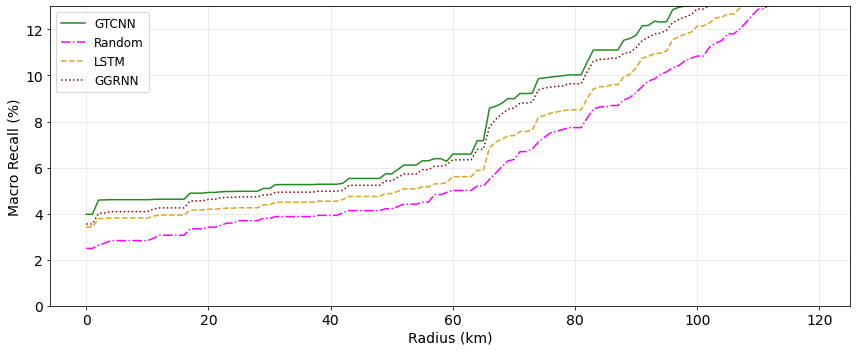

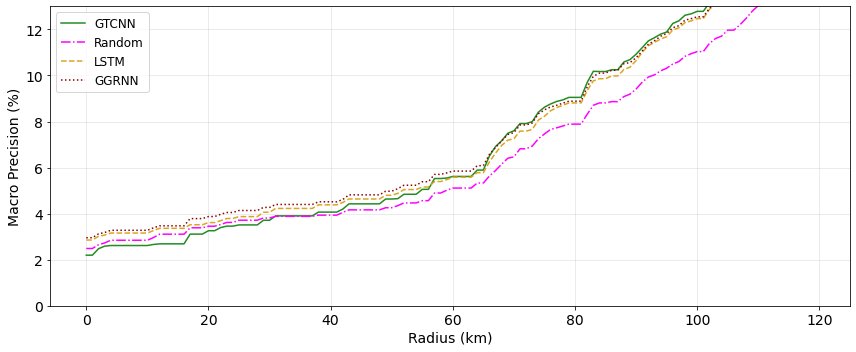

In [57]:
figsize = (12, 5)
LOG_SCALE = False

stations = labelToClass_dict.keys()
for metric in ['recalls', 'precisions', 'f1_scores']:
    GTCNN_mean_values = np.mean(np.array([metrics_GTCNN[station][metric] for station in stations]), axis=0)
    random_mean_values = np.mean(np.array([metrics_random[station][metric] for station in stations]), axis=0)
    LSTM_mean_values = np.mean(np.array([metrics_LSTM[station][metric] for station in stations]), axis=0)
    GRNN_mean_values = np.mean(np.array([metrics_GRNN[station][metric] for station in stations]), axis=0)
    
    plt.figure(figsize=figsize)
    
    x_values = np.arange(MIN_RADIUS, MAX_RADIUS, STEP)
    plt.plot(x_values, GTCNN_mean_values*100, label="GTCNN", color=colors['GTCNN'])
    plt.plot(x_values, random_mean_values*100, label="Random", linestyle='-.', color=colors['Random'])
    plt.plot(x_values, LSTM_mean_values*100, label="LSTM", linestyle='--', color=colors['LSTM'])
    plt.plot(x_values, GRNN_mean_values*100, label="GGRNN", linestyle=':', color=colors['GGRNN'])


    if LOG_SCALE:
        plt.yscale("log")
    else:
        lim=13
        plt.ylim(0, lim)
        plt.yticks(range(0, lim, 2))
#     

#     plt.axvline(x=170, color="gray", linestyle="--", alpha=0.5)

    titles = {'recalls': 'Recall', 'precisions': "Precision", 'f1_scores': "F1-score"}
    # general layout
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel("Macro " + titles[metric] + " (%)", fontsize=14)
    plt.xlabel("Radius (km)", fontsize=14)
    plt.grid(alpha=0.3)
    
    plt.legend(fontsize=12)
             
    
    plt.tight_layout()
    
    plt.savefig(f"radius-based_metrics_{metric}.pdf")

    plt.show()

# Accuracy

In [58]:
figsize = (12, 4)

plt.figure(figsize=figsize)

x_values = np.arange(MIN_RADIUS, MAX_RADIUS, STEP)
plt.plot(x_values, np.array(metrics_GTCNN['accuracies'])*100, label="GTCNN", color=colors['GTCNN'])
plt.plot(x_values, np.array(metrics_random['accuracies'])*100, label="Random", linestyle='-.', color=colors['Random'])
plt.plot(x_values, np.array(metrics_LSTM['accuracies'])*100, label="LSTM", linestyle='--', color=colors['LSTM'])
plt.plot(x_values, np.array(metrics_GRNN['accuracies'])*100, label="GGRNN", linestyle=':', color=colors['GGRNN'])



# plt.axvline(x=170, color="gray", linestyle="--", alpha=0.5)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)
plt.xlabel("Radius (km)", fontsize=14)
plt.grid(alpha=0.3)

plt.legend(fontsize=12)


plt.tight_layout()

plt.savefig(f"radius-based_metrics_accuracy.pdf")


plt.show()

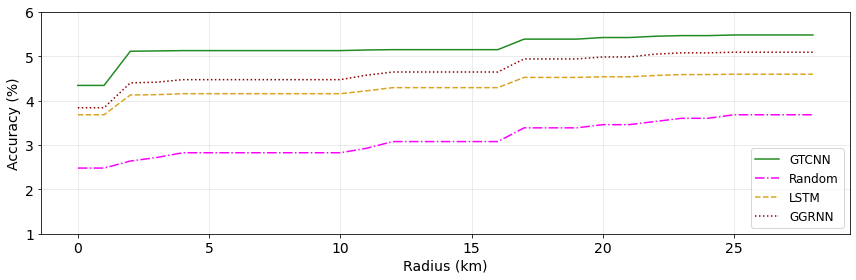

In [59]:
figsize = (12, 4)

plt.figure(figsize=figsize)

zoom_limit = 29
x_values = np.arange(MIN_RADIUS, zoom_limit, 1)
plt.plot(x_values, np.array(metrics_GTCNN['accuracies'][:zoom_limit])*100, label="GTCNN", color=colors['GTCNN'])
plt.plot(x_values, np.array(metrics_random['accuracies'][:zoom_limit])*100, label="Random", linestyle='-.', color=colors['Random'])
plt.plot(x_values, np.array(metrics_LSTM['accuracies'][:zoom_limit])*100, label="LSTM", linestyle='--', color=colors['LSTM'])
plt.plot(x_values, np.array(metrics_GRNN['accuracies'][:zoom_limit])*100, label="GGRNN", linestyle=':', color=colors['GGRNN'])


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)
plt.xlabel("Radius (km)", fontsize=14)
plt.grid(alpha=0.3)

plt.legend(fontsize=12)

plt.ylim(1, 6)
plt.tight_layout()

plt.savefig(f"radius-based_metrics_accuracy_zoom.pdf")

plt.show()

# Barplots for fixed values of radius

In [75]:
radius_values = [0, 20, 90]

In [76]:
metrics_dict = {}
for metric in ['recalls', 'precisions', 'f1_scores']:
    GTCNN_mean_values = np.mean(np.array([metrics_GTCNN[station][metric] for station in stations]), axis=0)
    random_mean_values = np.mean(np.array([metrics_random[station][metric] for station in stations]), axis=0)
    LSTM_mean_values = np.mean(np.array([metrics_LSTM[station][metric] for station in stations]), axis=0)
    GRNN_mean_values = np.mean(np.array([metrics_GRNN[station][metric] for station in stations]), axis=0)
    
    metric_dict = {
        'GTCNN': GTCNN_mean_values,
        'LSTM': LSTM_mean_values,
        'random': random_mean_values,
        'GGRNN': GRNN_mean_values
    }
    metrics_dict[metric] = metric_dict

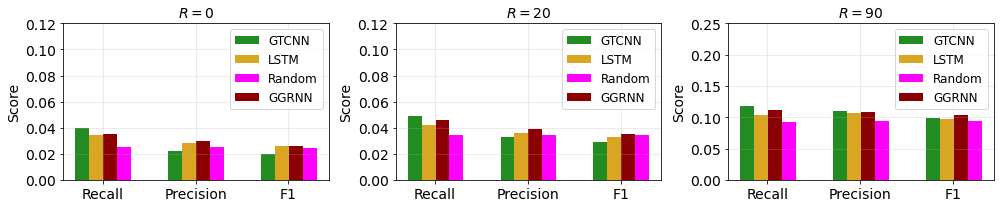

In [79]:
fig = plt.figure(figsize=(14, 3))

for idx, r in enumerate(radius_values):
    
    recalls = metrics_dict['recalls']
    precisions = metrics_dict['precisions']
    f1_scores = metrics_dict['f1_scores']
    
    barWidth = 0.15

    bars_GTCNN = [recalls['GTCNN'][r], precisions['GTCNN'][r], f1_scores['GTCNN'][r]]
    bars_LSTM = [recalls['LSTM'][r], precisions['LSTM'][r], f1_scores['LSTM'][r]]
    bars_RANDOM = [recalls['random'][r], precisions['random'][r], f1_scores['random'][r]]
    bars_GRNN = [recalls['GGRNN'][r], precisions['GGRNN'][r], f1_scores['GGRNN'][r]]

    r_GTCNN = [x - barWidth - 0.07  for x in np.arange(len(bars_GTCNN))]
    r_LSTM = [x - 0.07 for x in np.arange(len(bars_LSTM))]
    r_GRNN = [x + barWidth - 0.07 for x in np.arange(len(bars_GRNN))]
    r_RANDOM = [x + 2*barWidth - 0.07 for x in np.arange(len(bars_RANDOM))]

    plt.subplot(1, 3, idx+1)
    
    # Create blue bars
    plt.bar(r_GTCNN, bars_GTCNN, width = barWidth, capsize=7, label='GTCNN', color=colors['GTCNN'])
    plt.bar(r_LSTM, bars_LSTM,width = barWidth, capsize=7, label='LSTM', color=colors['LSTM'])
    plt.bar(r_RANDOM, bars_RANDOM,width = barWidth, capsize=7, label='Random', color=colors['Random'])
    plt.bar(r_GRNN, bars_GRNN,width = barWidth, capsize=7, label='GGRNN', color=colors['GGRNN'])

    
    # general layout
    plt.xticks(range(len(bars_GTCNN)), ['Recall', 'Precision', 'F1'], fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.grid(alpha=0.3)

    leg = plt.legend(fontsize=12)
    plt.ylim(0, 0.12 if r < 50 else 0.25)



    plt.title(f"$R = {r}$", fontsize=14)

plt.tight_layout()
plt.savefig(f"radius-based_metrics_barplots.pdf")
plt.show()

# Old metrics

In [36]:
# metrics_GTCNN = compute_metrics_with_growing_radius(cm_GTCNN, distances_matrix, MIN_RADIUS, MAX_RADIUS, STEP, labelToClass_dict, verbose=False)
# metrics_random = compute_metrics_with_growing_radius(cm_RANDOM, distances_matrix, MIN_RADIUS, MAX_RADIUS, STEP, labelToClass_dict, verbose=False)
# metrics_LSTM = compute_metrics_with_growing_radius(cm_LSTM, distances_matrix, MIN_RADIUS, MAX_RADIUS, STEP, labelToClass_dict, verbose=False)

In [37]:
# station_index = 1
# figsize = (12, 3)

# station_metrics_GTCNN = metrics_GTCNN.get(station_index, None)
# station_metrics_random = metrics_random.get(station_index, None)
# station_metrics_LSTM = metrics_LSTM.get(station_index, None)
# if station_metrics_GTCNN is None or station_metrics_random is None or station_metrics_LSTM is None:
#     print(f"Station not in classes")
# else:
    
#     for metric in ['recalls', 'precisions', 'f1_scores']:        
#         plt.figure(figsize=figsize)

#         x_values = np.arange(MIN_RADIUS, MAX_RADIUS, STEP)
#         plt.plot(x_values, station_metrics_GTCNN[metric], label="GTCNN")
#         plt.plot(x_values, station_metrics_random[metric], label="Random", linestyle=':')
#         plt.plot(x_values, station_metrics_LSTM[metric], label="LSTM", linestyle='--')

#         plt.tight_layout()
#         plt.legend()
#         plt.title(f"Station {station_index} | {metric}")
#         plt.show()

## Average values

In [38]:
# figsize = (12, 7)
# LOG_SCALE = True

# stations = labelToClass_dict.keys()
# for metric in ['recalls', 'precisions', 'f1_scores']:
#     GTCNN_mean_values = np.mean(np.array([metrics_GTCNN[station][metric] for station in stations]), axis=0)
#     random_mean_values = np.mean(np.array([metrics_random[station][metric] for station in stations]), axis=0)
#     LSTM_mean_values = np.mean(np.array([metrics_LSTM[station][metric] for station in stations]), axis=0)
    
#     plt.figure(figsize=figsize)
    
#     x_values = np.arange(MIN_RADIUS, MAX_RADIUS, STEP)
#     plt.plot(x_values, GTCNN_mean_values*100, label="GTCNN")
#     plt.plot(x_values, random_mean_values*100, label="Random", linestyle=':')
#     plt.plot(x_values, LSTM_mean_values*100, label="LSTM", linestyle='--')

#     plt.tight_layout()
#     plt.legend()
#     plt.title(f"Mean {metric}")
#     plt.grid(alpha=0.3)

#     if LOG_SCALE:
#         plt.yscale("log")
#     else:
#         plt.ylim(0, 70)
#         plt.yticks(range(0, 70, 2))
# #     

#     plt.show()

In [39]:
# n_stations = distances_matrix.shape[0]

# avg_n_stations_per_radius = []
# max_radius = 1300
# step = 0.5
# for radius in np.arange(0, max_radius, step):
#     n_stations_within_radius = []
    
#     for station_index in range(n_stations):
#         distances_for_station = distances_matrix[station_index]
#         stations_within_radius = [i for i in range(n_stations) if (distances_for_station <= radius)[i]]
#         n_stations_within_radius.append(len(stations_within_radius))
        
#     avg_n_stations_per_radius.append(np.mean(n_stations_within_radius))
    
# plt.figure(figsize=(12, 7))

# x_values = np.arange(0, max_radius, step)
# plt.plot(x_values, avg_n_stations_per_radius)
# plt.grid()
# plt.tight_layout()
# plt.title("Average number of stations within radius")

# plt.ylim(0, int(max(avg_n_stations_per_radius))+2)
# plt.yticks(range(0,int(max(avg_n_stations_per_radius))+2, 2))

# plt.show()